# *Imports*

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import random

random.seed(26)
np.random.seed(26)

from functions import *

---------------

# **Part 1 of the homework**

## Optimization via Gradient Descent (GD)

Given a set of *admissible solutions* $\Omega \subseteq \mathbb{R}^n$, an optimization problem is a problem of the form

$$
x^* = \arg\min_{x \in \mathbb{R}^n}f(x).
$$

If $\Omega = \mathbb{R}^n$, we say that the optimization is **unconstrained**. If $\Omega \subset \mathbb{R}^n$, the problem is **constrained**. In the following, we will always assume $\Omega = \mathbb{R}^n$, i.e. the unconstrained setup.

GD is an algorithm that iteratively updates the estimate of the solution, defined as:

$$
x_{k+1} = x_k - \alpha_k \nabla f(x_k), \quad k = 0, 1, \dots, \texttt{maxit}
$$

where the initial iterate, $x_0 \in \mathbb{R}^n$, is given as input and the **step-size** (equivalently, **learning rate**) $\alpha_k > 0$ controls the decay rapidity of $f(x)$ for any $k \in \mathbb{N}$.

To assure convergence to a stationary point. Since for GD, $p_k = - \nabla f(x_k)$, then the condition above is always satisfied:

$$
\nabla f(x_k)^T p_k = - \nabla f(x_k)^T \nabla f(x_k) = - || \nabla f(x_k) ||_2^2 \leq 0.
$$

Therefore, GD algorithm **always** converge to a stationary point in the limit of infinite iterations.

## Parameters

### Step Size
Selecting the step.  
There are three possible scenario that happens in selecting the step size:

* $\alpha_k$ is too small $\implies$ we never get to the minimum, getting closer and closer without reaching it. Moreover, we can easily get stuck on local minima when the _objective function_ is non convex. 
* $\alpha_k$ is too large $\implies$ we get stuck, bouncing back and forth around the minima.
* $\alpha_k$ is correct $\implies$ we reach the stationary point.


### Backtracking
Fortunately, there is a way to guarantee that the chosen step-size $\alpha_k$ is correct. Indeed, it is possible to prove that, if $\alpha_k$ satisfies the following conditions (known as **Wolfe Conditions**):

- *Sufficient decrease:* $ f(x_k - \alpha_k \nabla f(x_k)) \leq f(x_k) - c_1 \alpha_k || \nabla f(x_k) ||_2^2 $;
- *Curvature condition:* $\nabla f(x_k)^T \nabla f(x_k - \alpha_k \nabla f(x_k)) \leq c_2 ||  \nabla f(x_k)  ||_2^2$;

### Stopping criteria
**Stopping criteria 1:** Given a tollerance `tol_f`, for any iterate $x_k$, check whether or not $|| \nabla f(x_k) || \leq tol_f || \nabla f(x_0) ||$. If so, stop the iterations.

Unfortunately, this condition alone is not sufficient. Indeed, if the function $f(x)$ is almost flat around its minimum, then $|| \nabla f(x_k) ||$ will be small even if $x_k$ will be far from the true minimum. 


Consequently, its required to add another stopping criteria.

**Stopping criteria 2:** Given a tollerance `tol_x`, for any iterate $x_k$, check whether or not $|| x_k - x_{k-1} || \leq tol_x$. If so, stop the iterations


In [2]:
# This function are copy only to visualize the code 
# the reals functions are in functions.py
def backtracking_c(x, f, grad_f, params_f = None):
    """
    Backtracking method to find the best alpha that satisfies the backtracking condition.

    inputs:
    x: ndarray. The actual iterate x_k.
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    params_f: tuple. Tuple with the parameters of f.

    outputs:
    alpha: float. The value of alpha that satisfies the backtracking condition.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    # Calculating the gradient of f(x)
    grad_f_x = grad_f(x, params_f)
    # Calculating f(x)
    f_x = f(x, params_f)

    n = 0
    
    if grad_f_x.shape != (1,1):
        n = norm(grad_f_x,2)
    else:
        n = np.abs(grad_f_x)

    # Cheking the Sufficent Decrease Condition (Armijo Condition)
    # f(x - alpha*grad_f_x) <= f(x) - c*alpha*(grad_f_x^T)*grad_f_x
    # second Wolf condition (Curvature condition) is automatically satisfied
    while f((x - (alpha * grad_f_x).T).flatten(), params_f) > f_x - c * alpha * (n ** 2):
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def GD_c(f, grad_f, params_f = None, x0=0, maxit=1000, back_flag=False, alpha=0.1, tolf=1e-5, tolx=1e-5):
    """
    Gradient Descent method

    inputs:
    f: function. Function to be minimized(optimize).
    grad_f: function. Gradient of f.
    params_f: tuple. Tuple with the parameters of f.
    x0: ndarray. Initial guess of theta to start and optimize.
    maxit: int. Maximum number of iterations.
    tolf: float. Tolerance for the of the algorithm. Convergence is reached when the norm(grad_f(x_k),2) < tolf*norm(grad_f(x0),2).
    tolx: float. Tolerance for the x value. Convergence is reached when norm(x_k - x_k-1,2) < tolx.
    back_flag: bool. If True, the algorithm uses backtracking to update alpha.
    alpha: float. Value of alpha. Only used if back_flag is False.

    outputs:
    x: ndarray. (Hystory) Array that contains the value of x(theta) for each iterate.
    k: int. Number of iterations needed to converge.
    f_val: ndarray. (Hystory) Array of the value of each f(x).
    grads: ndarray. (Hystory) Array of gradient values.
    err: ndarray. (Hystory) Array of error values (normalize gradient).
    converge: bool. True if the method converges.
    message: str. Message that explains why the method stopped.
    """
    # Trashold to check if the values are diverging
    div_chek = 1e10

    # Calculate the initial alpha value
    if back_flag:
        alpha = backtracking(x0, f, grad_f, params_f)

    # Setting the initial values
    x, f_val, grads, err = [], [], [], []
    x.append(x0)
    f_val.append(f(x0, params_f))
    grads.append(grad_f(x0, params_f))
    err.append(norm(grads[0],2))

    for k in range(1,maxit):
        # Update the x value iterativly and saves the last value
        x_k = x[k-1] - (alpha*grad_f(x[k-1], params_f).flatten())
        x.append(x_k)
        if (x[k] > div_chek).any():
            message = "Diverging 1"
            # print(message)
            return x,k,f_val,grads,err,False,message
        
        # Update alpha with backtracking
        if back_flag:
            alpha = backtracking(x[k], f, grad_f, params_f)
        
        # Adding the values to be returned
        f_val.append(f(x[k], params_f))
        grads.append(grad_f(x[k], params_f))
        err.append(norm(grads[k],2))
        
        if (grads[k] > div_chek).any():
            message = "Diverging 2"
            # print(message)
            return x,k,f_val,grads,err,False,message
        

        # Check the stop condition
        if norm(grad_f(x[k], params_f),2) < tolf * norm(grad_f(x0, params_f),2):
            message = "Stop for f tolerance"
            # print(message)
            return x,k,f_val,grads,err,True,message
        if norm(x[k] - x[k-1],2) < tolx:
            message = "Stop for x tolerance"
            # print(message)
            return x,k,f_val,grads,err,True,message
        
    message = "Reached maxit"
    # print(message)
    return x,maxit,f_val,grads,err,True,message


### **FUNCTION 1**

$f : R^2 → R$ such that

$$f (x_1, x_2) = (x_1 − 3)^2 + (x_2 − 1)^2$$
for which the true optimum is $x^* = (3, 1)^T$ .

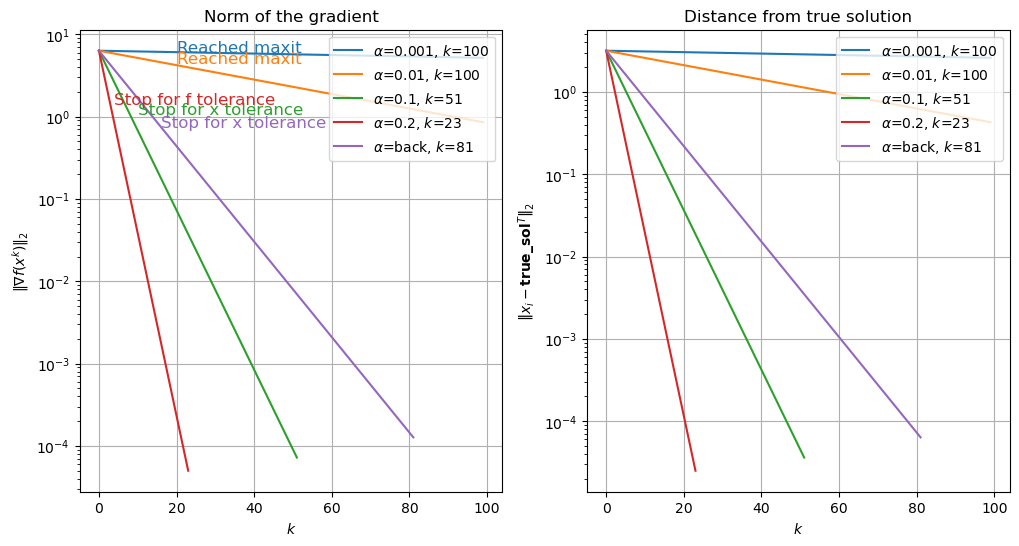

In [3]:

def f_1(x, ignore):
    return (x[0] - 3)**2 + (x[1] - 1)**2

def grad_f1(x, ignore):
    x = x.flatten()
    return np.array([[2*(x[0] - 3)],
                     [2*(x[1] - 1)]])

true_sol = np.array([[3],[1]])
x0 = np.array([0,0])
exercise_GD(f_1,grad_f1,x0=x0,true_sol=true_sol) 

For $\alpha<0.01$, the $GD$ speed appears to be logaritmic, and a solution is found after a $K = 80$ iterations. This suggests that smaller learning rates ensure convergence but at the cost of slower progress. The stability observed here could be due to the small step size, which avoids overshooting the optimal solution.

### **Function 2**

$f : \mathbb{R}^2 → \mathbb{R}$ such that:

$$f (x_1, x_2) = 10(x_1 − 1)^2 + (x_2 − 2)^2$$

for which the true optimum is $x^∗ = (1, 2)^T$.

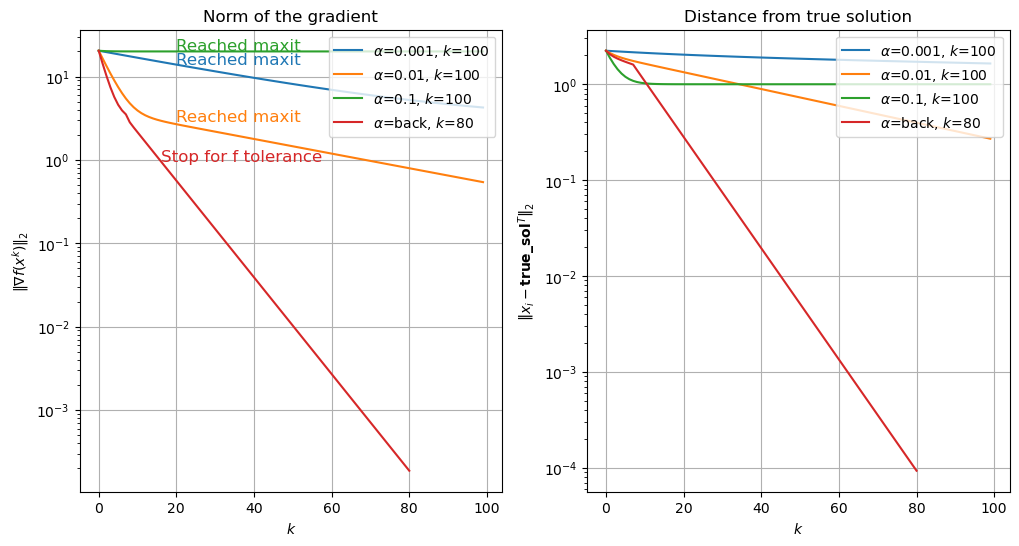

In [4]:
def f2(x, ignore):
    return 10*(x[0] - 1)**2 + (x[1] - 2)**2

def grad_f2(x, ignore):
    x = x.flatten()
    return np.array([[20*(x[0] - 1)],
                     [2*(x[1] - 2)]])

true_sol = np.array([[1],[2]])
x0 = np.array([0,0])
exercise_GD(f2,grad_f2,x0=x0,true_sol=true_sol)

In this case, despite varying values of $\alpha$, if *backpropagation* is not used to find an optimal $\alpha$, we will never reach the true solution. However, convergence might still occur for $K_{max}>100$ and for $\alpha<0.01$.  

### **Function 3**

$f : \mathbb{R}^n → \mathbb{R}$ such that:

$$ f (x) = \frac{1}{2} \lVert Ax − b \rVert _2^2$$

where $A \in \mathbb{R}^{n \times n}$ is the Vandermonde matrix associated with the vector $v \in \mathbb{R}^n$ that contains $n$ equispaced values in the interval $[0, 1]$, and $b \in \mathbb{R}^n$ is computed by first setting $x_{true} =
(1, 1, \dots , 1)^T$ and then $b = A x_{true}$. Try for different values of $n$ (e.g. $n = 5, 10, 15, \dots$ ).

n =  5


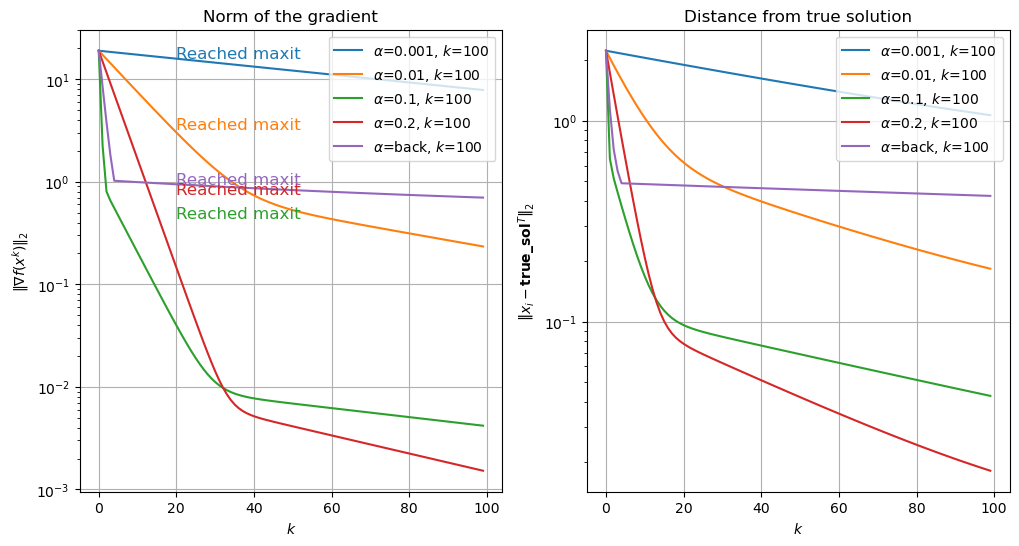

n =  10


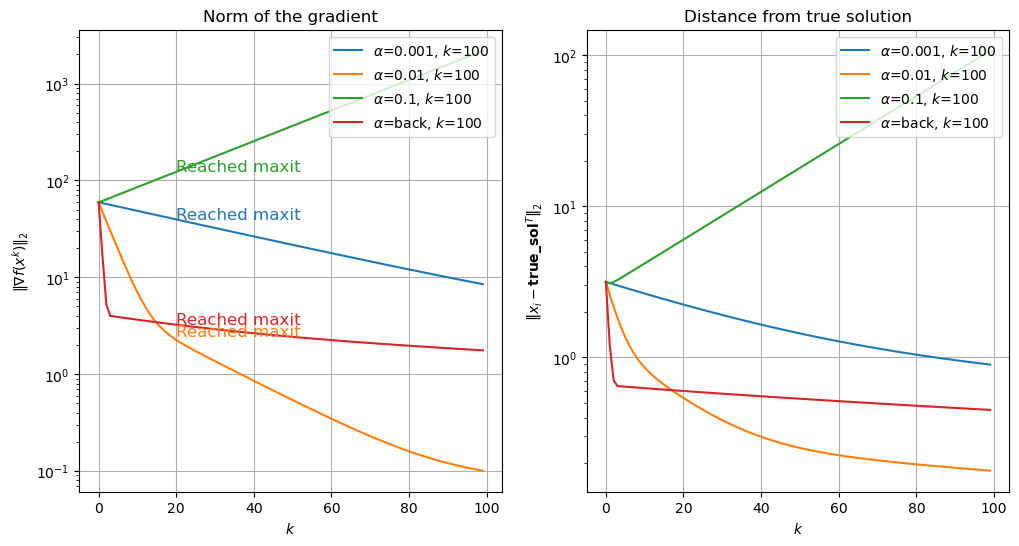

n =  20


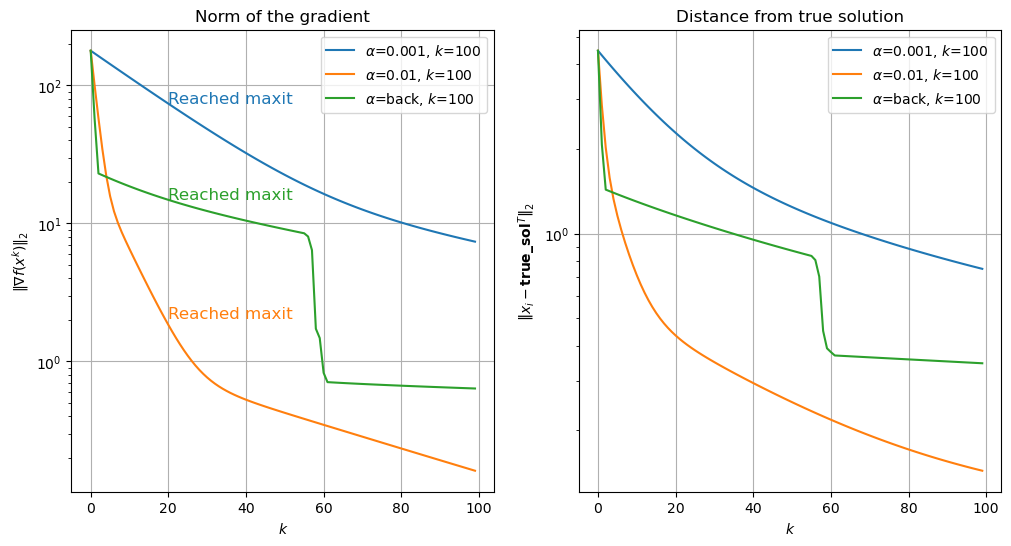

n =  50


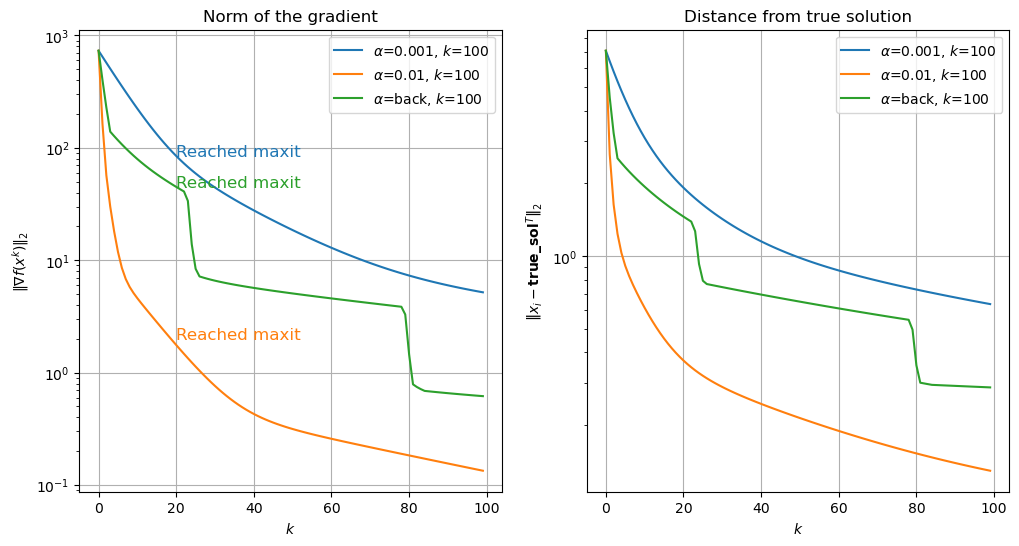

n =  100


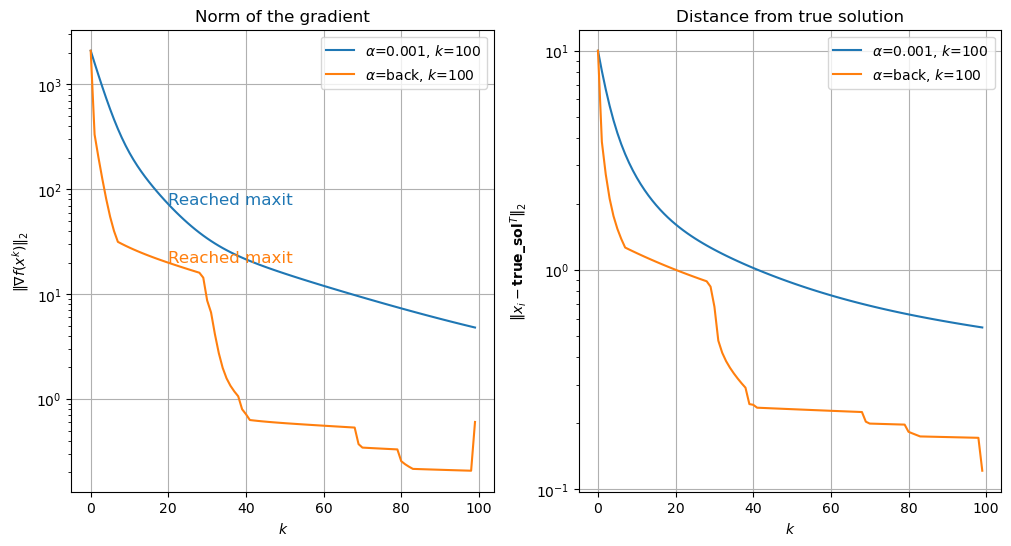

In [5]:
for n in [5,10,20,50,100]:
    print("n = ",n)
    v = np.linspace(0,1,n)
    A = np.vander(v)
    x_true = np.ones((1,n)).T
    b = A @ x_true

    def f3(x,ignore):
        return (norm(A @ x - b,2) ** 2)/2

    def grad_f3(x,ignore):
        M = A @ x - b.T
        return (M @ A).T

    x0 = np.zeros((n,))
    exercise_GD(f3,grad_f3,x0=x0,true_sol=x_true,dimensions=n)

In the case of the Vandermonde matrix, we observe that for small dimensions, convergence is almost always achieved. However, for dimensions greater than 10, convergence occurs only for consecutively smaller values of $\alpha$, while the remaining cases fail to converge.  
This behavior can be attributed to the ill-conditioning of the Vandermonde matrix, which becomes more pronounced as the dimensionality increases. When backpropagation or adaptive optimization methods are used, this issue does not occur, suggesting that such methods can better handle numerical instability and conditioning problems.

### **Function 4**

$f : \mathbb{R}^n → \mathbb{R}$ such that:

$$ f (x) = \frac{1}{2} \lVert Ax − b \rVert _2^2 + \frac{\lambda}{2} \lVert x \rVert _2^2$$

where $A$ and $b$ are the same of the exercise above, while $\lambda$ is a fixed value in the interval $[0, 1]$.
Try different values for $\lambda$.

lam =  0


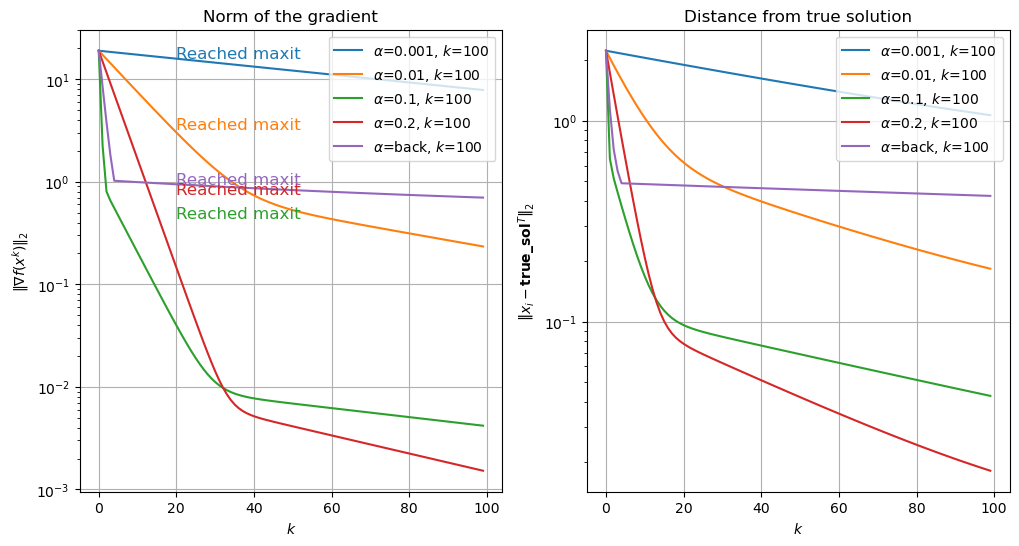

lam =  0.1


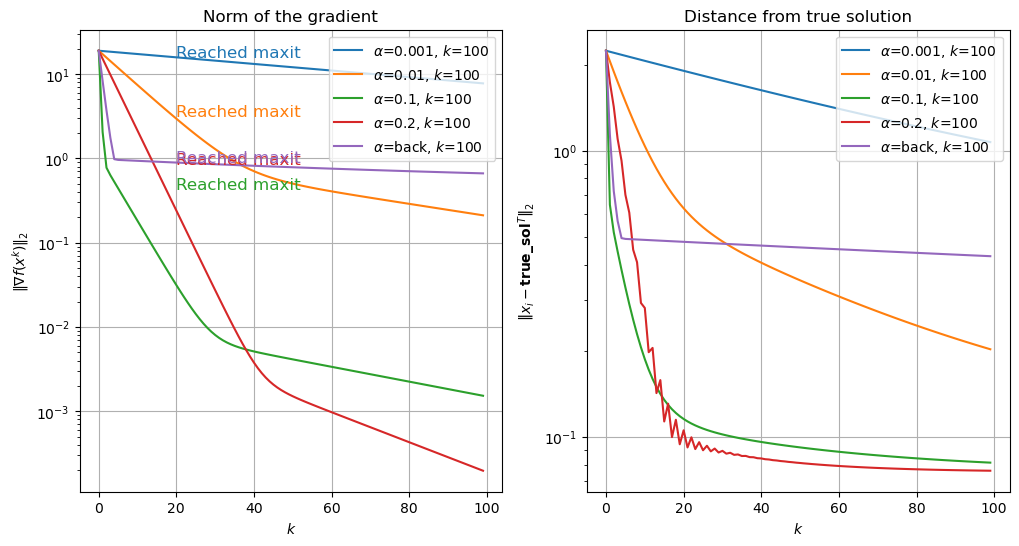

lam =  0.4


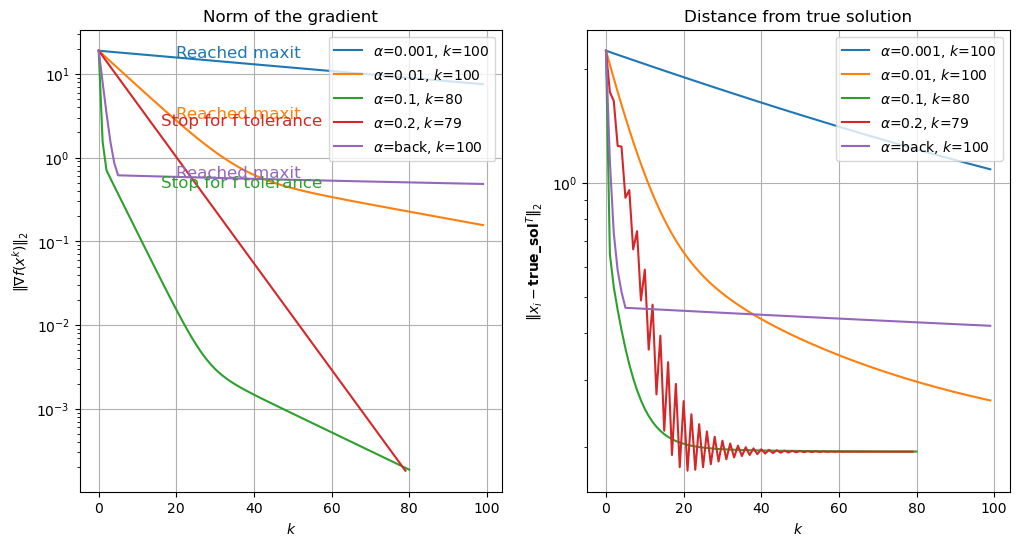

lam =  0.8


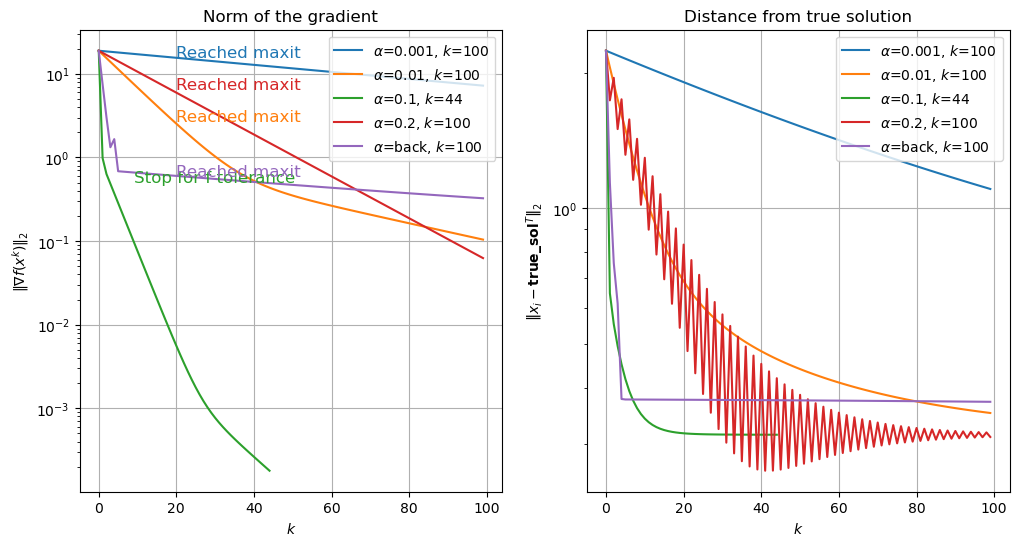

lam =  1


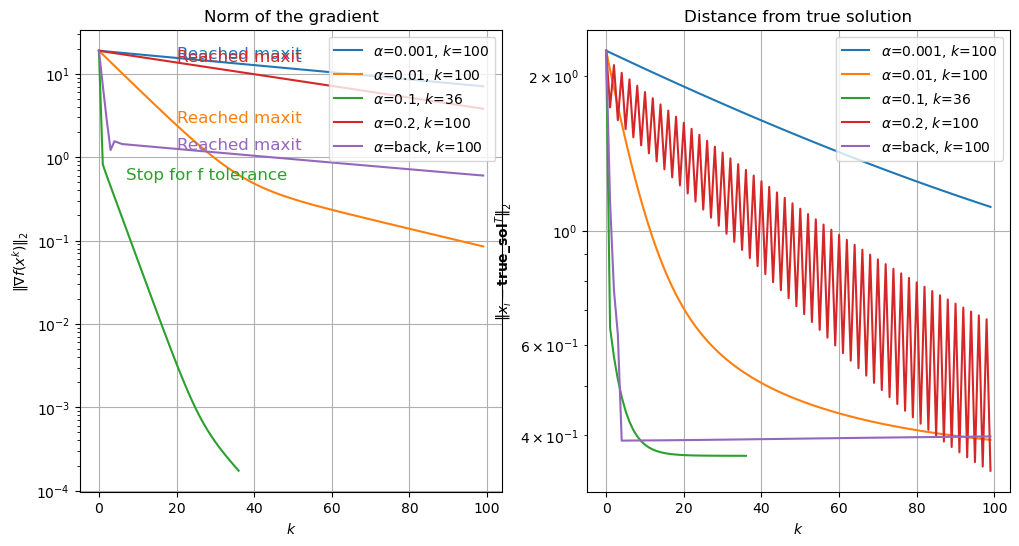

In [6]:
for l in [0,0.1,0.4,0.8,1]:
    print("lam = ", l)
    lam = l
    n = 5
    v = np.linspace(0,1,n)
    A = np.vander(v)
    x_true = np.ones((1,n)).T
    b = A @ x_true
    x0 = np.zeros((n,))

    def f4(x,ignore):
        return (norm(A @ x - b,2) ** 2)/2 + (lam * norm(x,2)**2 / 2)

    def grad_f4(x,ignore):
        M = A @ x - b.T
        return (M @ A).T + lam*x.reshape((n,1))

    exercise_GD(f4,grad_f4,x0=x0,true_sol=x_true,dimensions=n )

The error graph for $x$ relative to the true solution $x_{true}$ shows a zig-zag pattern as the iterations progress.  
This oscillatory behavior could be caused by an improper balance between the step size $\alpha$ and the regularization parameter $\lambda$.  
A larger $\lambda$ increases the curvature of the loss function, which, combined with an insufficiently small learning rate, can lead to overshooting or oscillations during optimization.

### **Function 5**

$f : \mathbb{R} → \mathbb{R}$ such that:

$$f (x) = x^4 + x^3 − 2x^2 − 2x $$

- Where the global minima is $x^* \approx 0.92222$ 

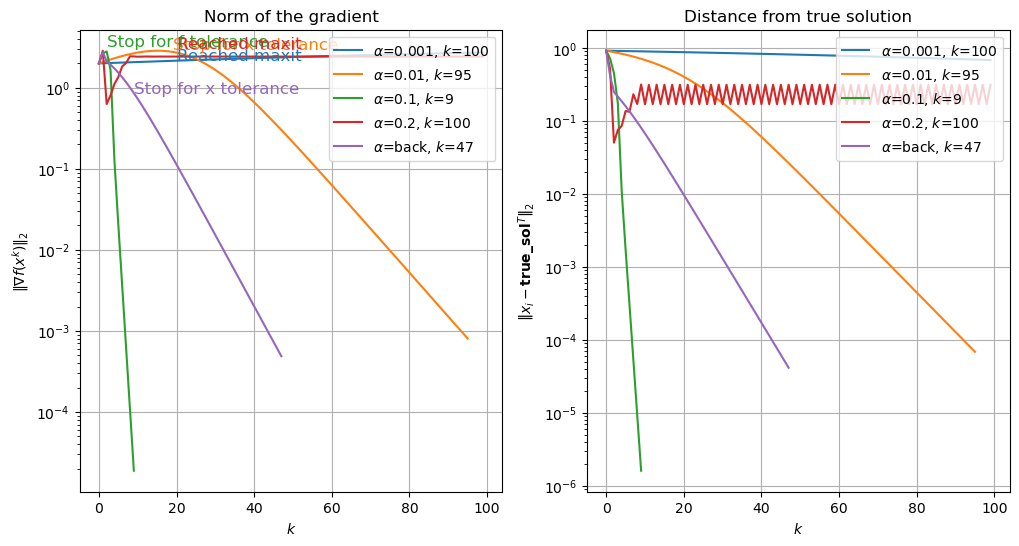

In [7]:
def f5(x,ignore):
    return x**4 + x**3 - 2*x**2 - 2*x

def grad_f5(x,ignore):
    return np.array([4*x**3 + 3*x**2 - 4*x - 2])

x0=np.array([0])
# Best value computed
true_sol = np.array([0.9222247929324218857020815]) 
exercise_GD(f5,grad_f5,x0=x0,true_sol=true_sol, dimensions=1)

For this polynomial function, it can be observed that with $\alpha=0.001$, the gradient magnitude increases steadily, and the solution seems to approach $x_{true}$ progressively.  
We can't be sure of its convergence because on the other hand, for $\alpha = 0.2$, the solution appears to "ping-pong" in a valley without making significant progress. 
This behavior is likely due to a learning rate that is too large, causing the updates to overshoot the minimum and oscillate around it rather than converging

alpha = backtracking


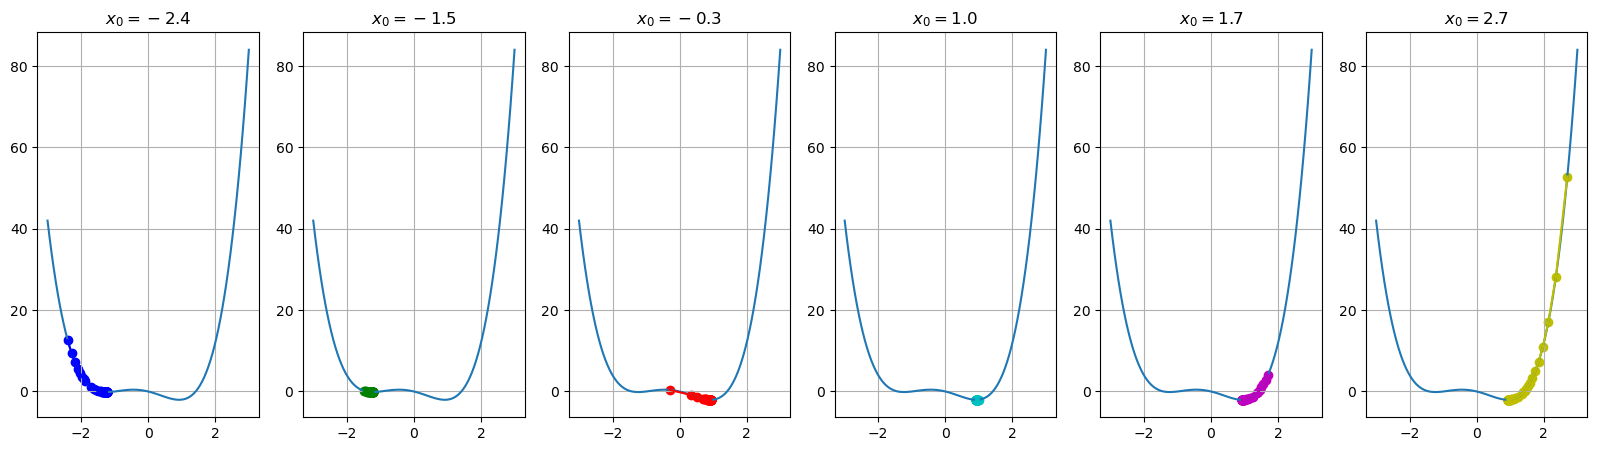

alpha =  0.001


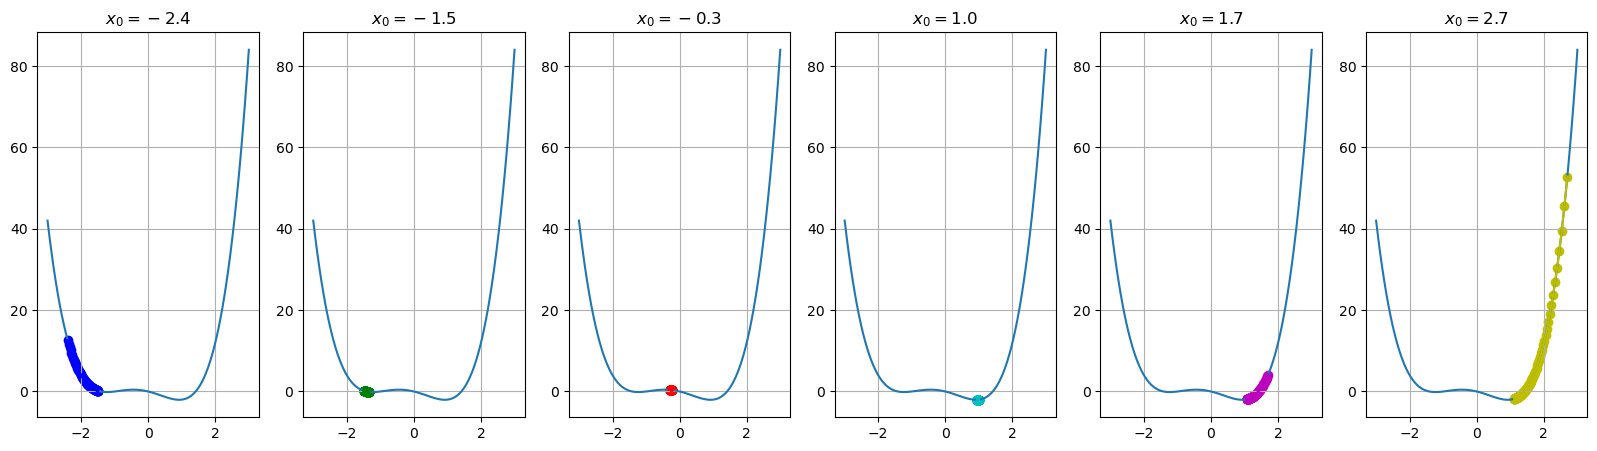

alpha =  0.01


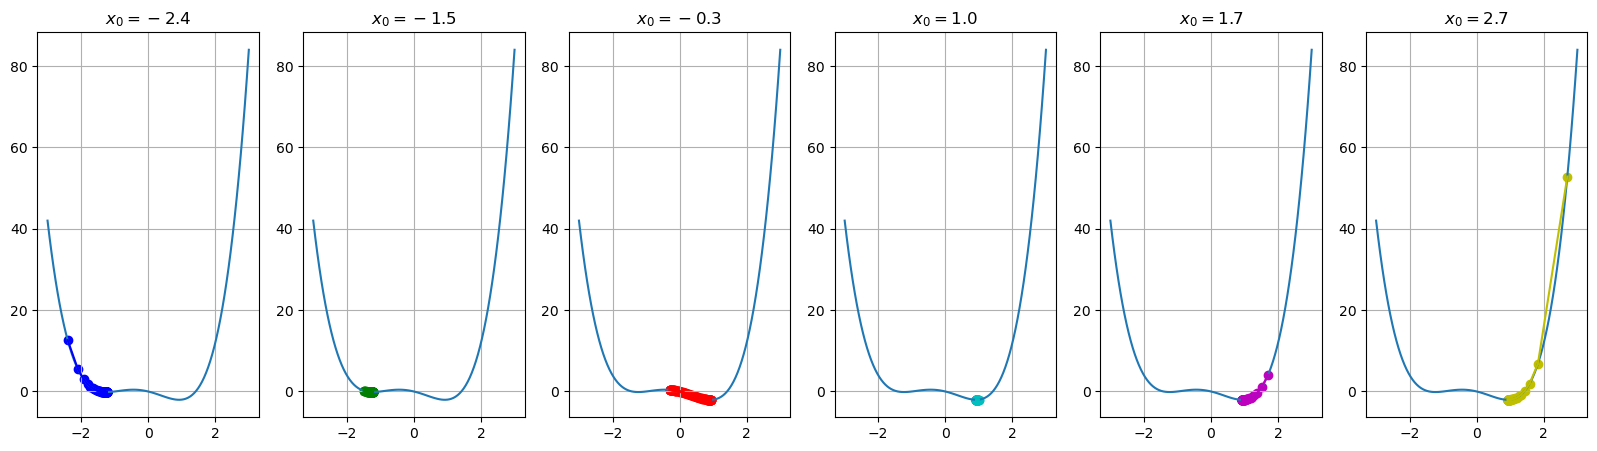

alpha =  0.1


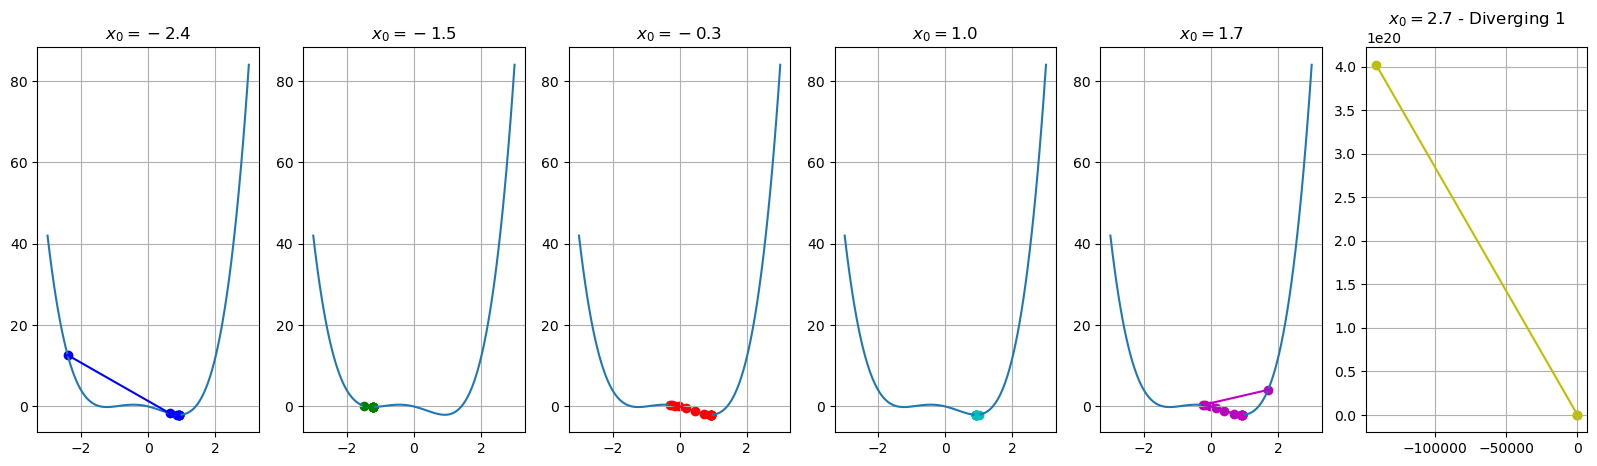

alpha =  0.2


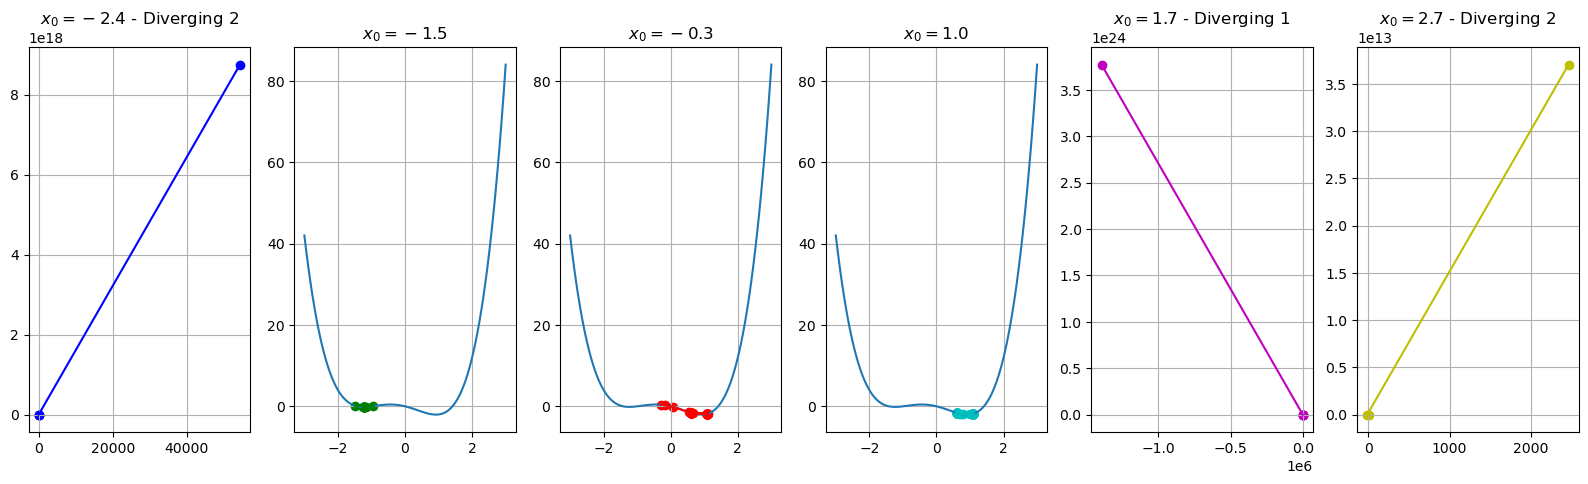

In [8]:
x0 = np.array([-2.4,-1.5,-0.3,1,1.7, 2.7])

print("alpha = backtracking")
plot_step_length(x0, f5, grad_f5)
for alpha in [0.001,0.01,0.1,0.2]:
    print("alpha = ",alpha)
    plot_step_length(x0, f5, grad_f5, alpha = alpha)

In this case is really important not only the magnitude of $\alpha$ but also the starting guess $x_0$.  
Note that we have stall for $\alpha=0.001$ and starting point $x_0 = - 0.3$.

----------------

# **Part 2 of the homework**

## Optimization via Stochastic Gradient Descent

Consider a dataset $(X,Y)$, where:

$$
X = \begin{bmatrix} x^1 & x^2 & \dots & x^N \end{bmatrix} \in \mathbb{R}^{d \times N}, \qquad Y = \begin{bmatrix} y^1 & y^2 & \dots & y^N \end{bmatrix} \in \mathbb{R}^N,
$$

together with a model $f_\theta(x)$, with vector of parameters $\theta$(*weights*). **Training** a ML model requires solving:

$$
\theta^* = \arg\min_{\theta} \ell(\theta; X, Y) = \arg\min_{\theta} \sum_{i=1}^N \ell_i(\theta; x^i, y^i). 
$$

Which can be solved by $GD$ algorithm, as

$$
\begin{cases}
	\theta_0 \in \mathbb{R}^d \\
	\theta_{k+1} = \theta_k - \alpha_k \nabla_\theta \ell(\theta_k; X, Y) = \theta_k - \alpha_k \sum_{i=1}^N \nabla_\theta \ell_i(\theta_k; x^i, y^i)
\end{cases}
$$

Where we used that $\nabla_\theta \ell(\theta_k; X, Y) = \nabla_\theta \sum_{i=1}^N \ell_i(\theta_k; x^i, y^i) = \sum_{i=1}^N \nabla_\theta \ell_i(\theta_k; x^i, y^i)$.

Even if it is easy to compute the gradient of $\ell_i(\theta; x^i, y^i)$ for any $i$, when the number of samples $N$ is large so the computation of the full gradient $\nabla_\theta \ell(\theta; X, Y)$ is prohibitive, mostly because of **memory limitations**.  
* Given a number $N_{batch} \ll N$ (usually called `batch_size`), randomly extract a subdataset $\mathcal{M}$ with $\|\mathcal{M}\| = N_{batch}$ from $(X, Y)$. This set will be called a **batch** (*Note that the random sampling at each iteration is done without replacement*);
	
* Approximate the true gradient as:

$$
\nabla_\theta \ell(\theta; X, Y) = \sum_{i=1}^N \nabla_\theta \ell_i(\theta; x^i, y^i),
$$ 
Since the optimization problem above is written as a **sum of independent terms** that only depends on the single datapoints, it satisfies the hypothesis for the application of the Stochastic Gradient Descent (SGD) algorithm.

### *Loss function*
The loss function I use is the *Mean Squared Error* (MSE), defined by:

$$
\ell(\theta; X, Y) := MSE(f_\theta(X), Y) = \frac{1}{N} \sum_{i=1}^N (f_\theta(x^i) - y^i)^2 = \sum_{i=1}^N  \underbrace{\frac{1}{N} (f_\theta(x^i) - y^i)^2}_{=: \ell_i(\theta; x^i, y^i)}.
$$
the gradient is defined by:
$$
\nabla_\theta MSE(f_\theta(X), Y) = \nabla_\theta \sum_{i=1}^N \frac{1}{N} (f_\theta(x^i) - y^i)^2 
$$
$$
=\ \sum_{i=1}^N \nabla_\theta (f_\theta(x^i) - y^i)^2 = 2 (f_\theta(x^i) - y^i) \nabla_\theta f_\theta(x^i)
$$
In SGD there is no way to check whether it reached the convergence and we can't use the backtracking algorithm, since we can't obviously compute the gradient of $\ell(\theta; X, Y)$ to check its distance from zero.  
As a consequence, the algorithm will stop only after reaching the fixed number of **epochs**, and we must set a good value for the step size $\alpha_k$ by hand.
1 **epoch** = repeat GD on the `batch size` until the full dataset has been extracted.

### *Plynomial function*
The function we want to optimize is a non-linear regression model, given a number $K > 0$. In this case is a $K-1$-th degree polynomial. For this reason, $f_\theta(x)$ is called **polynomial regression model** for this choice of $\phi_j(x)$. :
$$
    f_\theta(x) = \sum_{j=0}^K \phi_j(x) \theta_j,
$$

$$
    f_\theta(x) = \phi^T(x) \theta
$$
$$
\Phi(X) = \begin{bmatrix} 1 & 1 & \dots & 1 \\ x^1 & x^2 & \dots & x^N \\ (x^1)^2 & (x^2)^2 & \dots & (x^N)^2 \\ \vdots & \vdots & \dots & \vdots \\ (x^1)^{K-1} & (x^2)^{K-1} & \dots & (x^N)^{K-1} \end{bmatrix}, \qquad Y = \begin{bmatrix} y^1 & y^2 & \dots & y^N \end{bmatrix},
$$
where the functions $\phi_1, \phi_2, \dots, \phi_K$ are called **feature vectors**. 

Note that, if $\theta = [\theta_1, \theta_2, \dots, \theta_K]^T$ and $\phi(x) = [\phi_1(x), \phi_2(x), \dots, \phi_K(x)]^T$, then

$$
    f_\theta(x) = \phi^T(x) \theta
$$

which implies that $f_\theta(x)$ is a *linear function* in $\theta$, for any choice of $\phi_j(x)$. The *non-linearity* is therefore only as a function of $x$.

A classical choice for the feature vector is $\phi_j(x) = x^{j-1}$. In this way, for a given $K>0$, $\phi(x)$ represents the vector of the first $K$ monomial in $x$, i.e.

$$
    \phi(x) = [1, x, x^2, \dots, x^{K-1}]^T
$$

and $f_\theta(x)$ is a $K-1$-th degree polynomial. For this reason, $f_\theta(x)$ is called **polynomial regression model** for this choice of $\phi_j(x)$. 

When the loss function $\ell(\theta; X, Y)$ is the Mean Squared Error, training a polynomial regression model is similar to the training of the linear regression model. then:

$$
\ell(\theta; X, Y) = \frac{1}{N} || \Phi(X)^T \theta - Y ||_2^2,
$$

whose normal equations read:

$$
\Phi(X)\Phi(X)^T \theta = \Phi(X) Y.
$$


* Split the dataset into training and test set, with a proportion of 80% training and 20% test. 
* Fix a degree $K$ for the polynomial. 
* Train the polynomial regression model on the training set via the SGD and GD algorithms.
* Train the polynomial regression model on the `poly_regression_small.csv` dataset, **without** splitting it into training and test set.

In [9]:
ds = pd.read_csv("poly_regression_large.csv")
# Inspect the data
print(f"Shape of the data large: {ds.shape}")
# Convert data into a matrix
data = np.array(ds)

# the first colums is useless
X = data[:, 1]
Y = data[:, 2]
print()
print(f"X shape = {X.shape}, Y shape = {Y.shape}")

(X_train, Y_train), (X_test, Y_test) = split_data(X, Y, per_train=0.8)
print(f"X train shape = {X_train.shape}, Y test shape = {X_test.shape}")
print()
# same for small dataset
ds2 = pd.read_csv("poly_regression_small.csv")
print(f"Shape of the data small: {ds2.shape}")
data2 = np.array(ds2)
X2 = data2[:, 1]
Y2 = data2[:, 2]
print(f"X2 shape = {X2.shape}, Y2 shape = {Y2.shape}")
ds.head()

Shape of the data large: (1000, 3)

X shape = (1000,), Y shape = (1000,)
Train test split = 800, 200
X train shape = (800,), Y test shape = (200,)

Shape of the data small: (50, 3)
X2 shape = (50,), Y2 shape = (50,)


,Unnamed: 0,x,y
0,0,0.000000,0.058679
1,1,0.001001,0.035014
2,2,0.002002,-0.081214
3,3,0.003003,0.119974
4,4,0.004004,-0.092172


In [10]:
degree_poly = 4
theta0 = np.zeros((degree_poly, ))
alpha= 0.1
# if we take a batch size bigger for the smoller dataset the SGD become the same of GD
batch_size=20
n_epochs=5000

D = (X,Y)

D2 = (X2,Y2)

# SGD for the large dataset
theta_history, loss_history, grad_norm_history =SGD_poly(
    loss_mse_poly, grad_loss_mse_poly, D, degree_poly = degree_poly ,
    theta0 = theta0, alpha = alpha, batch_size = batch_size,
    n_epochs = n_epochs)

# SGD for the small dataset
theta_history_2, loss_history_2, grad_norm_history_2 = SGD_poly(
    loss_mse_poly, grad_loss_mse_poly, D2, degree_poly = degree_poly ,
    theta0 = theta0, alpha = alpha, batch_size = batch_size, 
    n_epochs = n_epochs)

# GD for the large dataset and backtraking
theta_history_gd,maxit,loss_history_gd,_,grad_norm_gd,_,message = GD(
    loss_mse_poly, grad_loss_mse_poly, params_f = D , x0 = theta0, 
    maxit=n_epochs, back_flag=True)
print("MSE for the large dataset with GD and backtraking as stopped for",message)

# GD for the small dataset and backtraking
theta_history_gd_2,maxit_2,loss_history_gd_2,_,grad_norm_gd_2,_,message = GD(
    loss_mse_poly, grad_loss_mse_poly, params_f = D2 , x0 = theta0, 
    maxit=n_epochs, back_flag=True)
print("MSE for the small dataset with GD and backtraking as stopped for",message)

# GD for the large dataset and alpha fixed 0.1
theta_history_gd_alpha,maxit_alpha,loss_history_gd_alpha,_,grad_norm_gd_alpha,_,message = GD(
    loss_mse_poly, grad_loss_mse_poly, params_f = D, x0 = theta0, 
    maxit=n_epochs, alpha=alpha)
print("MSE for the large dataset with GD and fixed alpha as stopped for",message)


# GD for the small dataset and alpha fixed 0.1
theta_history_gd_alpha_2,maxit_alpha_2,loss_history_gd_alpha_2,_,grad_norm_gd_alpha_2,_,message = GD(
    loss_mse_poly, grad_loss_mse_poly, params_f = D2, x0 = theta0, 
    maxit=n_epochs, alpha=alpha)
print("MSE for the small dataset with GD and fixed alpha as stopped for",message)

MSE for the large dataset with GD and backtraking as stopped for Reached maxit
MSE for the small dataset with GD and backtraking as stopped for Reached maxit
MSE for the large dataset with GD and fixed alpha as stopped for Reached maxit
MSE for the small dataset with GD and fixed alpha as stopped for Reached maxit


* Compare the performance of the three regression model computed above, using:
  $$
  MSE = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$


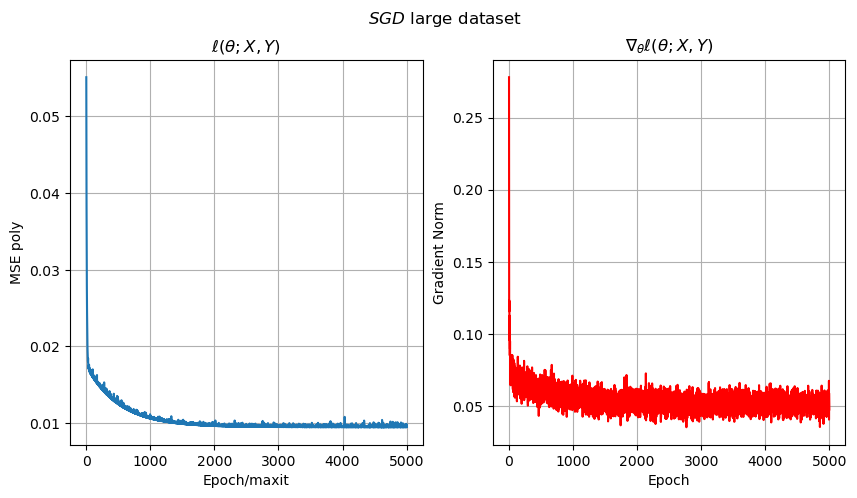

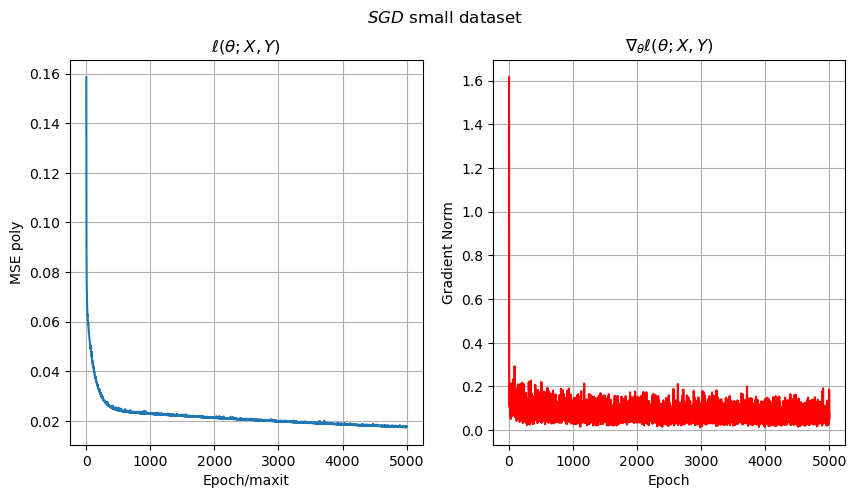

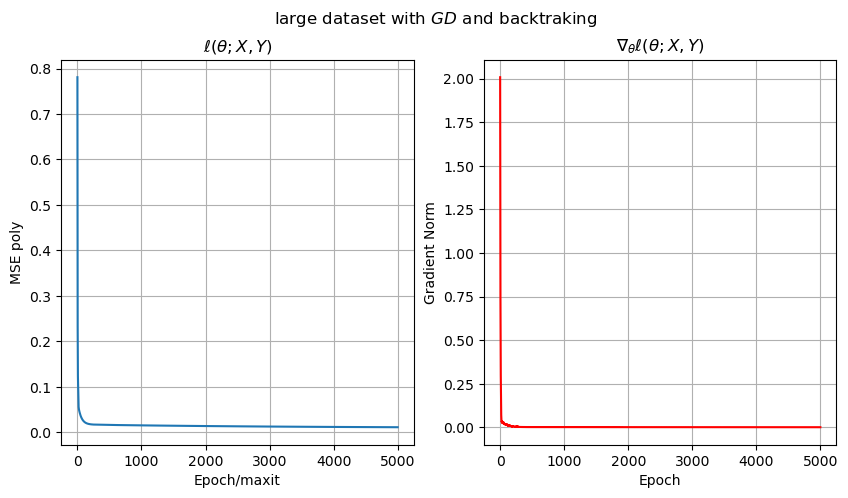

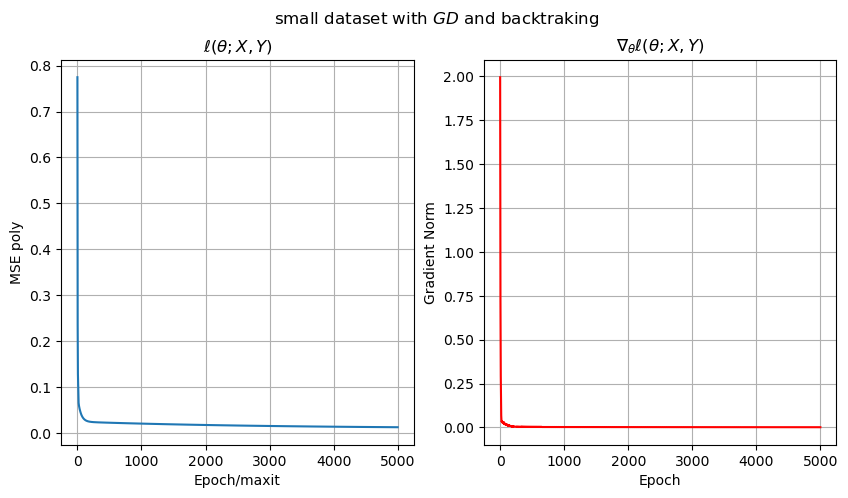

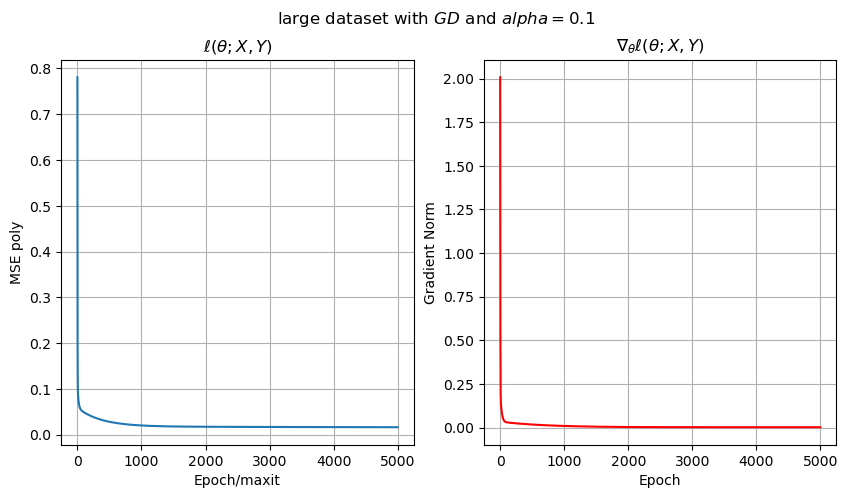

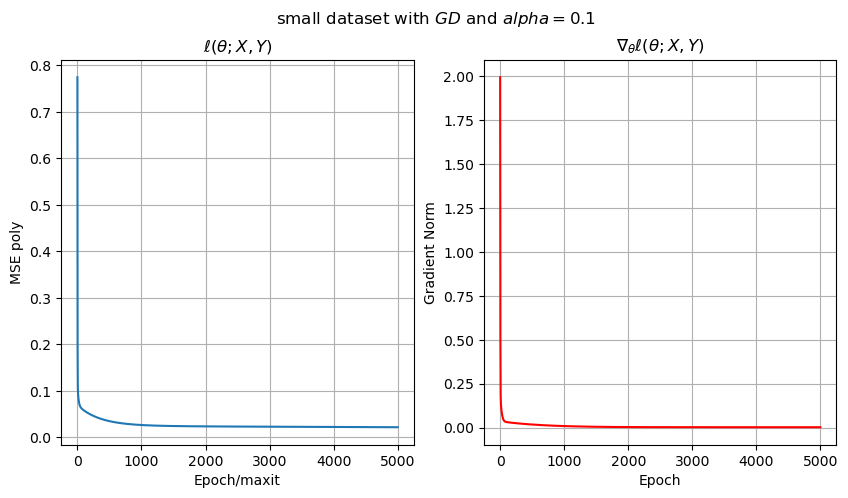

MSE for the SGD large dataset =  0.009
MSE for the SGD small dataset =  0.014
MSE for the large dataset with GD and backtraking =  0.012
MSE for the small dataset with GD and backtraking =  0.01
MSE for the small dataset with GD =  0.017
MSE for the large dataset with GD =  0.018


In [11]:

plot_loss(loss_history, grad_norm_history, title = "$SGD$ large dataset")
plot_loss(loss_history_2, grad_norm_history_2, title = "$SGD$ small dataset ")
plot_loss(loss_history_gd, grad_norm_gd, title = "large dataset with $GD$ and backtraking ")
plot_loss(loss_history_gd_2, grad_norm_gd_2, title = "small dataset with $GD$ and backtraking")
plot_loss(loss_history_gd_alpha, grad_norm_gd_alpha, title = "large dataset with $GD$ and $alpha=0.1$")
plot_loss(loss_history_gd_alpha_2, grad_norm_gd_alpha_2, title = "small dataset with $GD$ and $alpha=0.1$")

print("MSE for the SGD large dataset = ", round(mse_error(X_test, Y_test, theta_history[-1]),3))
print("MSE for the SGD small dataset = ", round(mse_error(X_test, Y_test, theta_history_2[-1]),3))
print("MSE for the large dataset with GD and backtraking = ", round(mse_error(X_test, Y_test, theta_history_gd[-1]),3))
print("MSE for the small dataset with GD and backtraking = ", round(mse_error(X_test, Y_test, theta_history_gd_2[-1]),3))
print("MSE for the small dataset with GD = ", round(mse_error(X_test, Y_test, theta_history_gd_alpha_2[-1]),3))
print("MSE for the large dataset with GD = ", round(mse_error(X_test, Y_test, theta_history_gd_alpha[-1]),3))


##### *SGD small vs large*
The results indicate that $SGD$ performs best on the large dataset with a mean squared error of $0.009$ compared to $0.014$ on the small dataset.  
This difference can be explained by the fact that in larger datasets $SGD$ benefits from the diversity of the data and achieves better generalization. 
##### *Batch size $= 20$* 
Since the batch size is fixed at $20 SGD$ efficiently samples smaller portions of the data at each step ensuring a smoother optimization trajectory with the large daset.  
In contrast on the small dataset the fixed batch size means the model essentially uses most of the data in every step which is close to full-batch $GD$.
The comparable value can be found after using the same batch number.
As we expected for what we said before, for $GD$ with backtracking on the small dataset the mean squared error is $0.01$ is slightly better than the performance of $SGD$.
##### *SGD large vs GD large*
On the large dataset the fixed learning rate in SGD likely outperformed $GD$ with backtracking due to the stochastic nature of SGD which avoids overfitting and handles large data more efficiently.
##### *GD large vs small*
On the small dataset $GD$ with backtracking achieves a mean squared error of $0.0101$ which nearly matches the performance of the large dataset.  
The backtracking line search dynamically adjusts the learning rate during training which helps improve convergence especially for small datasets. 
In small datasets, the optimization landscape tends to be simpler and less noisy compared to larger datasets. Since the optimization surface is typically simpler with fewer local minima or saddle points, backtracking line search finds an appropriate learning rate faster. 

MSE for the SGD small dataset =  0.017


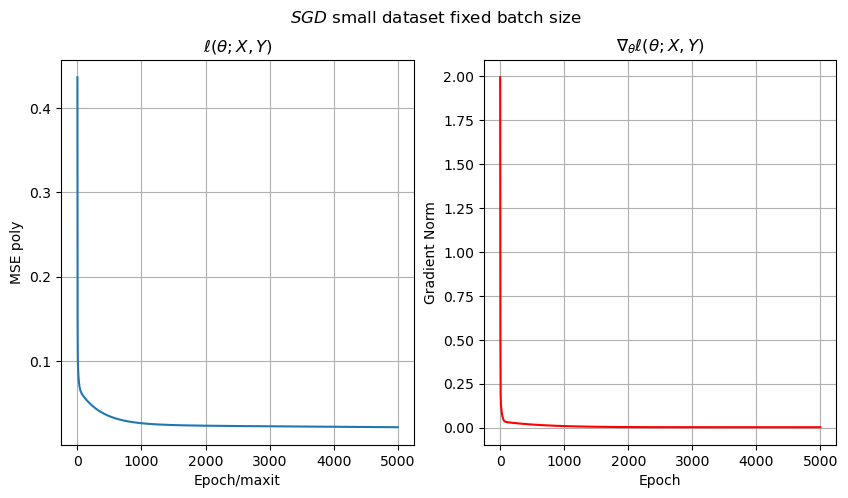

In [12]:
# we wont the same proposition respect to the big data set
batch_size=X.shape[0]//20
# SGD for the small dataset
theta_history_3, loss_history_3, grad_norm_history_3 = SGD_poly(
    loss_mse_poly, grad_loss_mse_poly, D2, degree_poly = degree_poly ,
    theta0 = theta0, alpha = alpha, batch_size = batch_size, 
    n_epochs = n_epochs)


print("MSE for the SGD small dataset = ", round(mse_error(X_test, Y_test, theta_history_3[-1]),3))
plot_loss(loss_history_3, grad_norm_history_3, title = "$SGD$ small dataset fixed batch size")

This suggests that the larger dataset provides greater diversity and better generalization while the small dataset may suffer from insufficient stochastic updates due to its size.

* Repeat the experiment by varying the degree $K$ of the polynomial.

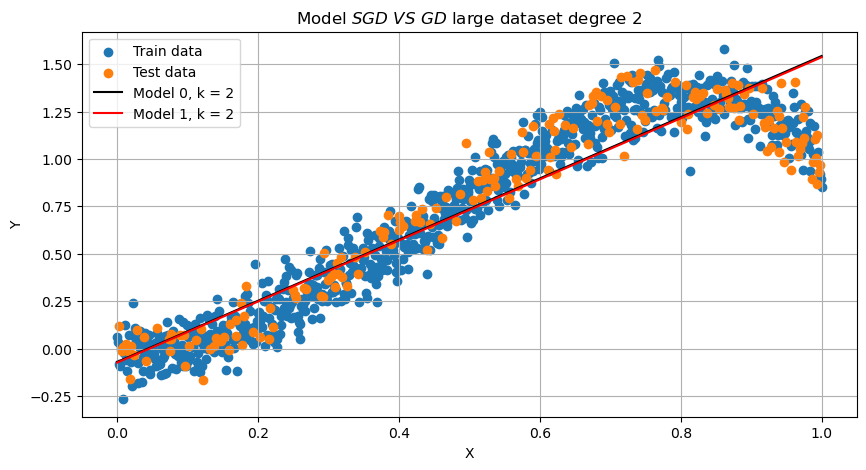

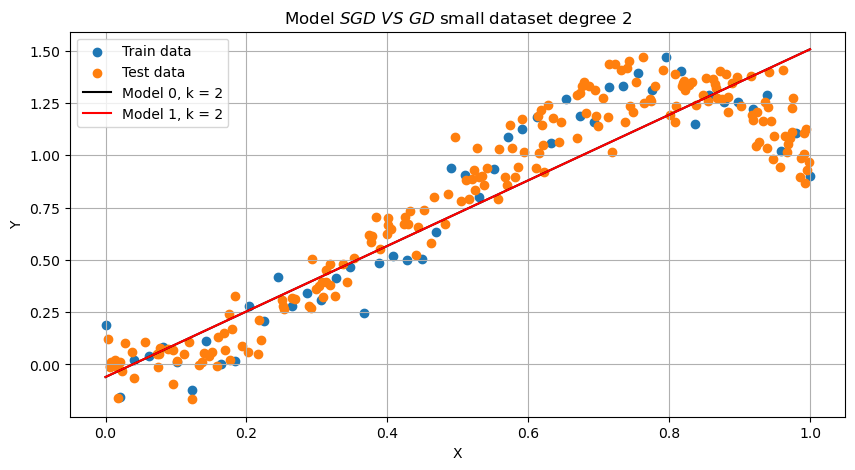

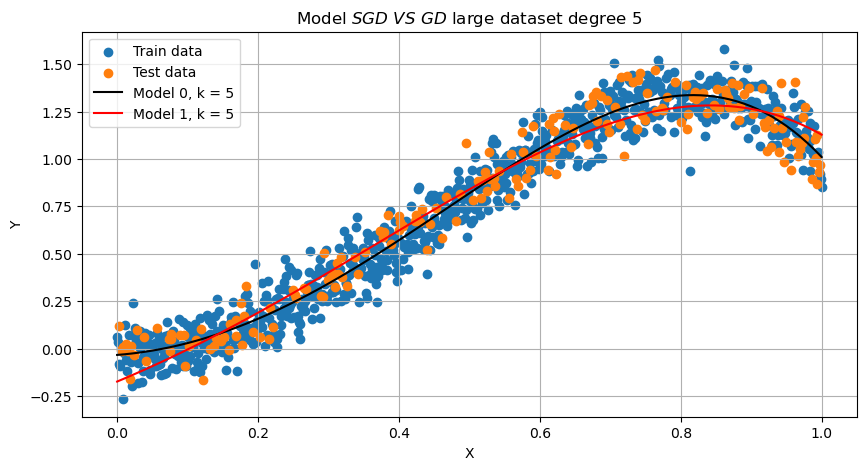

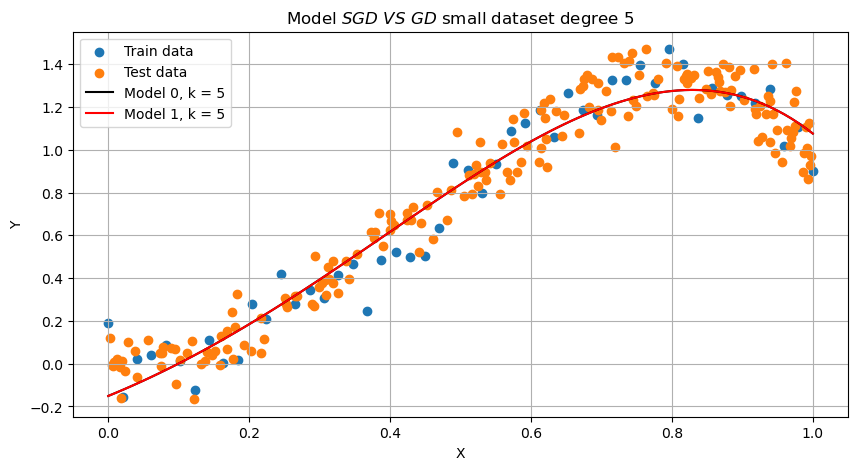

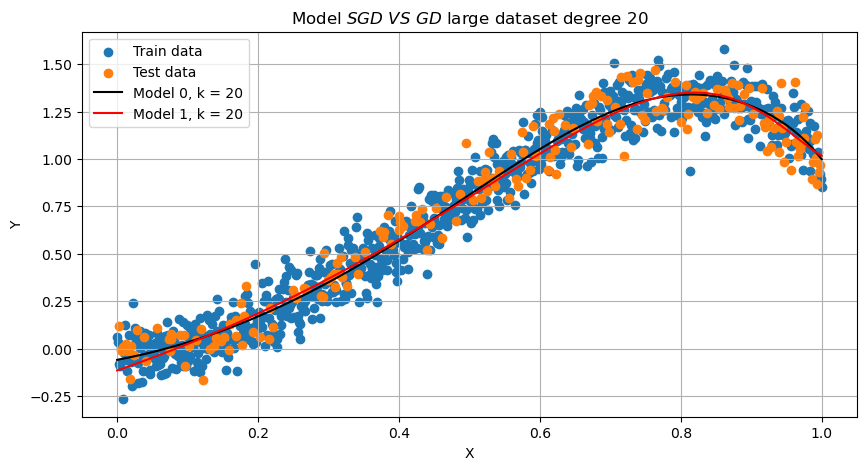

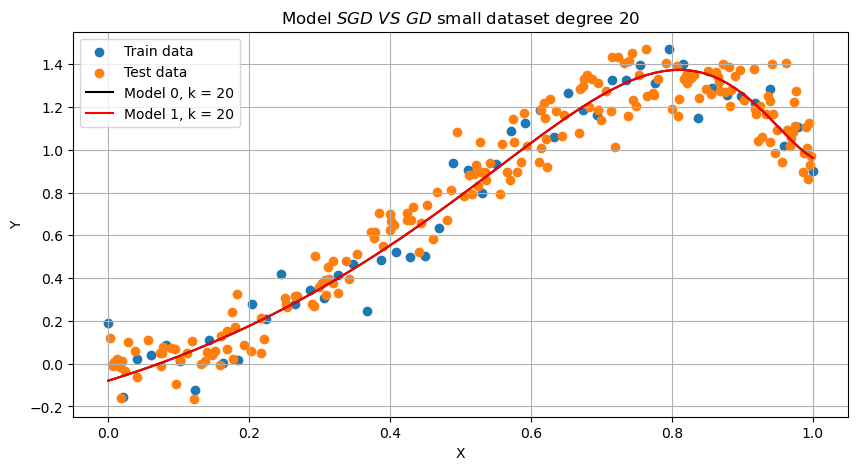

In [13]:
k_l = [2,5,20]
batch_size_small=X.shape[0]//20

saving_thetas_k5 = []

for i,k in enumerate(k_l):
    degree_poly = k
    theta0 = np.zeros((degree_poly, ))
    # SGD for the large dataset
    theta_history, loss_history, grad_norm_history =SGD_poly(
        loss_mse_poly, grad_loss_mse_poly, D, degree_poly = degree_poly ,
        theta0 = theta0, alpha = alpha, batch_size = batch_size,
        n_epochs = n_epochs)
    # GD for the large dataset alpha fixed 0.1
    theta_history_gd_alpha,maxit_alpha,loss_history_gd_alpha,_,grad_norm_gd_alpha,_,message = GD(
        loss_mse_poly, grad_loss_mse_poly, params_f = D, x0 = theta0, 
        maxit=n_epochs, alpha=alpha)

    # SGD for the small dataset
    theta_history_2, loss_history_2, grad_norm_history_2 = SGD_poly(
        loss_mse_poly, grad_loss_mse_poly, D2, degree_poly = degree_poly ,
        theta0 = theta0, alpha = alpha, batch_size = batch_size_small, 
        n_epochs = n_epochs)
    # GD for the small dataset and alpha fixed 0.1
    theta_history_gd_alpha_2,maxit_alpha_2,loss_history_gd_alpha_2,_,grad_norm_gd_alpha_2,_,message = GD(
        loss_mse_poly, grad_loss_mse_poly, params_f = D2, x0 = theta0, 
        maxit=n_epochs, alpha=alpha)
    if k == 5:
        saving_thetas_k5 = [theta_history,theta_history_gd_alpha,theta_history_2,theta_history_gd_alpha_2]

    plot_poly_regression(X_train, Y_train, X_test, Y_test, [theta_history[-1],theta_history_gd_alpha[-1]], VS=True, title=f"$SGD$ $VS$ $GD$ large dataset degree {k}")
    plot_poly_regression(X2, Y2, X_test, Y_test, [theta_history_2[-1],theta_history_gd_alpha_2[-1]], VS=True, title=f"$SGD$ $VS$ $GD$ small dataset degree {k}")


##### $K = 2$
As we can see having only two parameters to estimate, bring the result to be an equal straight line in both cases of the dataset $D$ and $D2$ and regardless of $SGD$ and $GD$.  
This is due to the fact that k = 2 is too low a value to approximate the problem.   
The former situation, which is called **underfitting**, describe a model too rigid, with the implication that it can potentially be unable to capture the complexity of the data.
##### $K = 5$
In this case we will have something similar to $K = 4$ where the $SDG$ manages to capture more information than the $GD$ when there is more data, while when there is little the performances become similar.  
##### $K = 20$
With the last two plot we casn notice that the differences decrease even more given the large amount of parameters.  
This quantity surely exceeds the number necessary to approximate the problem.

* Now we compare the parameters learned by the three models with the true parameter $\theta^* = [0, 0, 4, 0, -3]$.  ($K=5$)

In [15]:
name_model = ["SGD large dataset","GD large dataset","SGD small dataset","GD small dataset"]
theta_true = np.array([0,0,4,0,-3])
for i,thetas in enumerate(saving_thetas_k5):
    # rel error of the theta
    print(f"rel error for model {name_model[i]} = ", round(np.linalg.norm(theta_true - thetas[-1], 2)/np.linalg.norm(theta_true, 2),4))
    print(theta_true)
    print([round(t,4) for t in thetas[-1]])
    print()

rel error for model SGD large dataset =  0.1945
[ 0  0  4  0 -3]
[-0.0334, 0.2906, 3.3194, 0.6057, -3.1723]

rel error for model GD large dataset =  0.6804
[ 0  0  4  0 -3]
[-0.1738, 1.5584, 1.3636, -0.0889, -1.5315]

rel error for model SGD small dataset =  0.5784
[ 0  0  4  0 -3]
[-0.1507, 1.3472, 1.718, 0.0139, -1.8524]

rel error for model GD small dataset =  0.5784
[ 0  0  4  0 -3]
[-0.1507, 1.3473, 1.7178, 0.0138, -1.8523]

